In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [3]:
X = pd.read_csv('X_features.csv')
y = pd.read_csv('y_target.csv').squeeze()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=5),
    'AdaBoost': AdaBoostClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=100, max_depth=6, eval_metric='logloss', verbosity=0),
    'LightGBM': LGBMClassifier(random_state=42, n_estimators=100, max_depth=6, verbose=-1),
    'SVM (RBF)': SVC(random_state=42, kernel='rbf', probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

In [7]:
results = {}

In [8]:
print("\n" + "="*60)
print("RESULTADOS DOS MODELOS")
print("="*60)

for name, model in models.items():
    # Treinar com dados normalizados
    model.fit(X_train_scaled, y_train)
    
    # Previsões
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Métricas
    auc = roc_auc_score(y_test, y_pred_proba)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')

    results[name] = {
        'AUC-ROC': auc,
        'CV AUC': cv_scores.mean(),
        'Precisão': classification_report(y_test, y_pred, output_dict=True)['1']['precision'],
        'Recall': classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    }
    
    print(f"\n{name}:")
    print(f"  AUC-ROC Teste: {auc:.3f}")
    print(f"  CV AUC (5-fold): {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")


RESULTADOS DOS MODELOS

Logistic Regression:
  AUC-ROC Teste: 0.999
  CV AUC (5-fold): 0.999 (+/- 0.002)

Decision Tree:
  AUC-ROC Teste: 0.994
  CV AUC (5-fold): 0.996 (+/- 0.002)

Random Forest:
  AUC-ROC Teste: 0.999
  CV AUC (5-fold): 0.999 (+/- 0.003)

Gradient Boosting:
  AUC-ROC Teste: 0.999
  CV AUC (5-fold): 0.998 (+/- 0.003)

AdaBoost:
  AUC-ROC Teste: 0.998
  CV AUC (5-fold): 0.999 (+/- 0.002)

XGBoost:
  AUC-ROC Teste: 0.998
  CV AUC (5-fold): 0.999 (+/- 0.002)

LightGBM:
  AUC-ROC Teste: 0.998
  CV AUC (5-fold): 0.998 (+/- 0.003)

SVM (RBF):
  AUC-ROC Teste: 0.997
  CV AUC (5-fold): 0.999 (+/- 0.001)

KNN:
  AUC-ROC Teste: 0.998
  CV AUC (5-fold): 0.999 (+/- 0.002)

Naive Bayes:
  AUC-ROC Teste: 0.999
  CV AUC (5-fold): 0.999 (+/- 0.002)


In [9]:
best_model_name = max(results, key=lambda k: results[k]['AUC-ROC'])
print(f"\n MELHOR MODELO: {best_model_name}")
print(f"   AUC-ROC: {results[best_model_name]['AUC-ROC']:.3f}")


 MELHOR MODELO: Logistic Regression
   AUC-ROC: 0.999


Testando uma rede neural:

In [12]:
def neural_network(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim, 
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),  # Camada extra fina
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # Learning rate menor
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    mode='min'
)


In [13]:
nn_model = neural_network(X_train_scaled.shape[1])

early_stop = EarlyStopping(
    monitor='val_auc',
    patience=15,
    restore_best_weights=True,
    mode='max'
)

print("Treinando a rede neural...\n")
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Treinando a rede neural...

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4442 - auc: 0.6962 - loss: 0.8111 - val_accuracy: 0.9779 - val_auc: 0.9941 - val_loss: 0.4571
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9514 - auc: 0.9814 - loss: 0.3307 - val_accuracy: 0.9971 - val_auc: 0.9987 - val_loss: 0.0959
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - auc: 0.9986 - loss: 0.0996 - val_accuracy: 0.9971 - val_auc: 0.9990 - val_loss: 0.0467
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9979 - auc: 0.9994 - loss: 0.0493 - val_accuracy: 0.9971 - val_auc: 0.9984 - val_loss: 0.0421
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9968 - auc: 0.9990 - loss: 0.0437 - val_accuracy: 0.9971 - val_auc: 0.9968 - val_loss: 0.0412
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9965 - auc: 0.9986 - loss: 0.0435 - val_accuracy: 0.9971 - val_auc: 0.9969 - val_loss: 0.0406
Epoch 

In [14]:
losses = pd.DataFrame(history.history)

<Axes: >

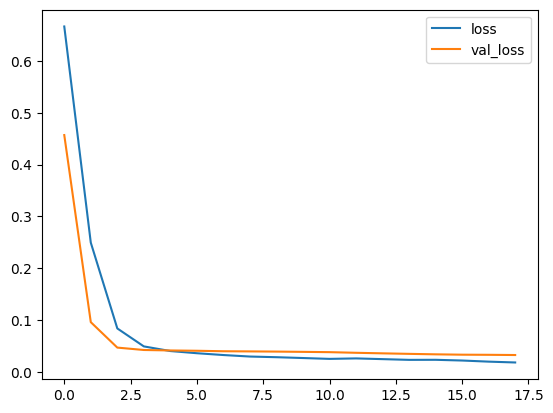

In [15]:
losses[['loss','val_loss']].plot()

In [16]:
# Probabilidades previstas pelo modelo no conjunto de teste
y_pred_proba = nn_model.predict(X_test_scaled, verbose=0).flatten()

In [17]:
y_pred = (y_pred_proba >= 0.5).astype(int)

In [18]:
auc_roc = roc_auc_score(y_test, y_pred_proba)

In [19]:
f1 = f1_score(y_test, y_pred)

In [20]:
cm = confusion_matrix(y_test, y_pred)

In [21]:
print(f"AUC-ROC (teste): {auc_roc:.4f}")
print(f"F1-Score (teste): {f1:.4f}")
print("\nMatriz de confusão (teste):")
print(cm)

AUC-ROC (teste): 0.9986
F1-Score (teste): 0.9967

Matriz de confusão (teste):
[[2387    2]
 [   2  609]]


In [23]:
nn_model.save('modelo_neural_network.keras')